# Movie Reviews Analysis and Word Embedding - Natural Language Processing (NLP)
This repository contains multiple lab activities focused on analyzing and processing movie reviews using natural language processing (NLP) and machine learning techniques.

In [26]:
# Importing Libraries
import pandas as pd
import spacy
from tqdm import tqdm
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [4]:
# Load spaCy model for NLP tasks
nlp = spacy.load("en_core_web_sm")

### 1. Load the Dataset

In [5]:
# Load movie review dataset
data = pd.read_csv('C:/Users/femij/Downloads/lab4/train.csv')

### 2. Processing the Data (Activity 1: Processing Movie Reviews)

In [6]:
# Function to extract adjectives from text
def get_adjs(doc):
    return [token.text for token in doc if token.pos_ == "ADJ"]

# Function to extract named entities (PERSON, NORP, FAC, ORG)
def get_ents(doc):
    return [ent.text for ent in doc.ents if ent.label_ in {"PERSON", "NORP", "FAC", "ORG"}]

# Function to count the number of sentences in a review
def get_number_of_sents(doc):
    return len(list(doc.sents))

# Initialize counters for adjectives and entities
number_of_sents, pos_adj_counter, neg_adj_counter, ent_counter = [], Counter(), Counter(), Counter()

In [7]:
# Processing reviews
for review, sentiment in tqdm(data.to_records(index=False), desc="Processing reviews"):
    doc = nlp(review)
    
    # Extract adjectives, entities, and sentence count
    adjs = get_adjs(doc)
    ents = get_ents(doc)
    num_sents = get_number_of_sents(doc)
    
    # Append sentence count to list
    number_of_sents.append(num_sents)
    
    # Update counters for entities and adjectives based on sentiment
    ent_counter.update(ents)
    if sentiment == "positive":
        pos_adj_counter.update(adjs)
    elif sentiment == "negative":
        neg_adj_counter.update(adjs)

Processing reviews: 100%|████████████████████████████████████████████████████████| 25000/25000 [26:33<00:00, 15.69it/s]


In [8]:
# Add sentence counts to the dataframe
data["number_of_sents"] = number_of_sents

### 3. Exploring the data (Visualization)

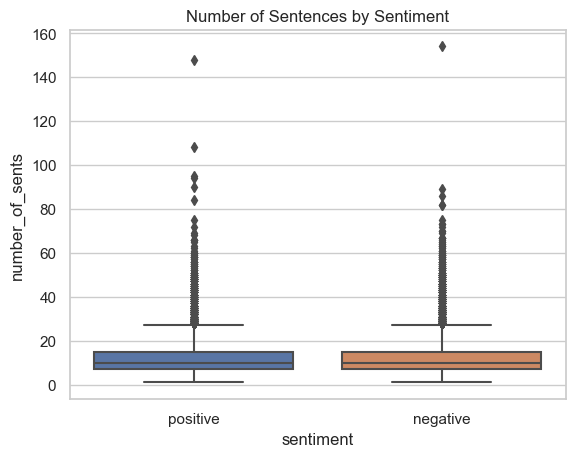

In [9]:
# Boxplot: Number of sentences grouped by sentiment
sns.set(style="whitegrid")
sns.boxplot(x="sentiment", y="number_of_sents", data=data)
plt.title("Number of Sentences by Sentiment")
plt.show()

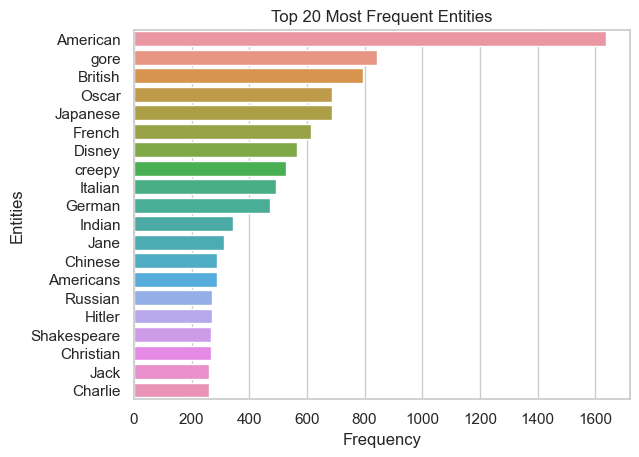

In [10]:
# Bar plot: Top 20 most frequent entities
top20_ent = ent_counter.most_common(20)
y = [t[0] for t in top20_ent]
x = [t[1] for t in top20_ent]
sns.barplot(x=x, y=y)
plt.title("Top 20 Most Frequent Entities")
plt.xlabel("Frequency")
plt.ylabel("Entities")
plt.show()

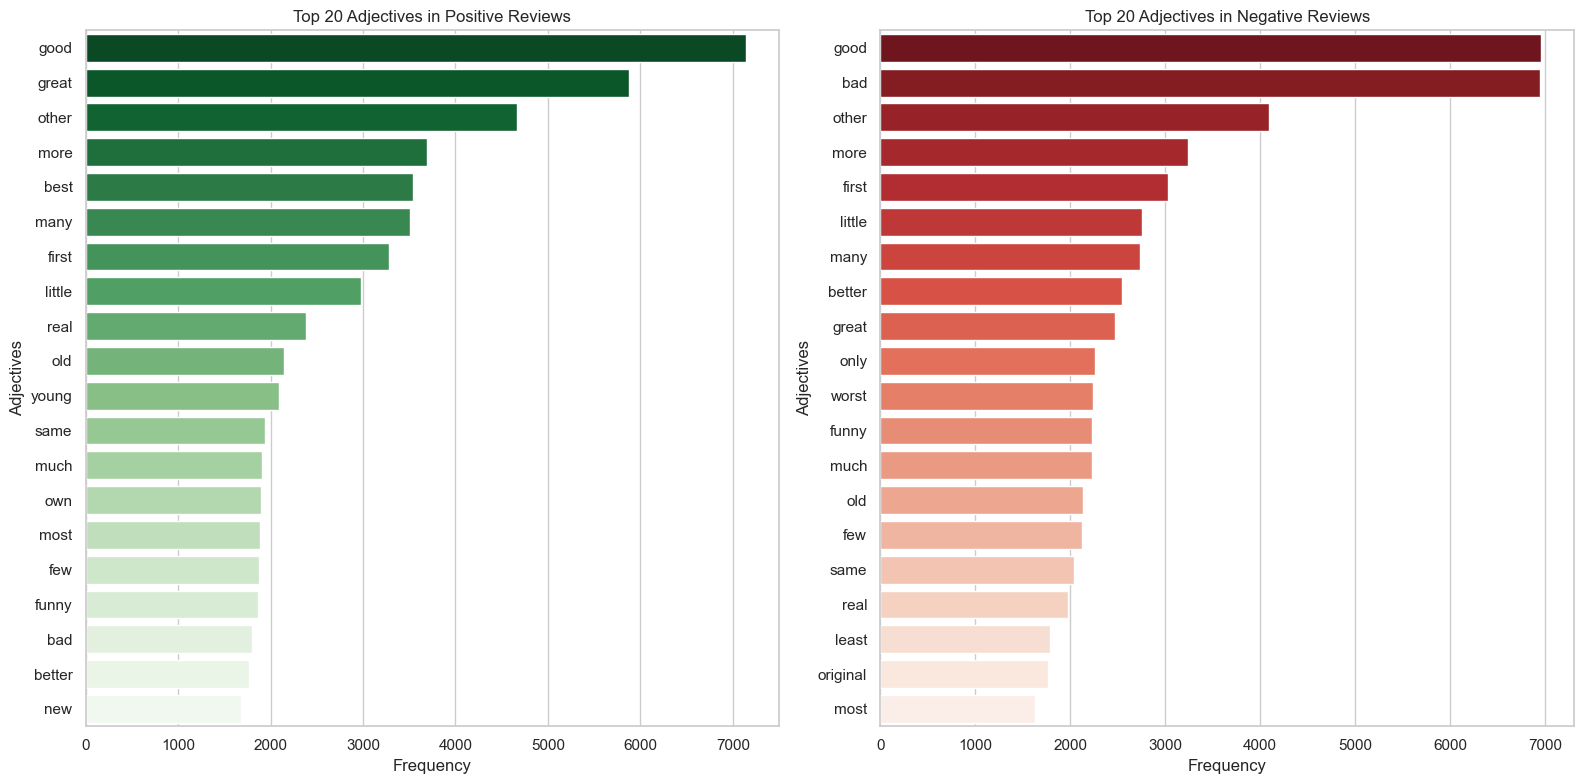

In [11]:
# Bar plots: Top 20 adjectives in positive and negative reviews
_, axes = plt.subplots(1, 2, figsize=(16, 8))

# Positive adjectives
top20_pos_adj = pos_adj_counter.most_common(20)
y_pos = [t[0] for t in top20_pos_adj]
x_pos = [t[1] for t in top20_pos_adj]
sns.barplot(x=x_pos, y=y_pos, ax=axes[0], palette="Greens_r")
axes[0].set_title("Top 20 Adjectives in Positive Reviews")
axes[0].set_xlabel("Frequency")
axes[0].set_ylabel("Adjectives")

# Negative adjectives
top20_neg_adj = neg_adj_counter.most_common(20)
y_neg = [t[0] for t in top20_neg_adj]
x_neg = [t[1] for t in top20_neg_adj]
sns.barplot(x=x_neg, y=y_neg, ax=axes[1], palette="Reds_r")
axes[1].set_title("Top 20 Adjectives in Negative Reviews")
axes[1].set_xlabel("Frequency")
axes[1].set_ylabel("Adjectives")

plt.tight_layout()
plt.show()

### 4. Modeling (Activity 2: Topic Modeling on Movie Reviews)

In [18]:
# Step 1: Clean the reviews (simple text cleaning)
def clean_text(text):
    # Lowercasing, removing punctuation, and non-alphabetical characters (basic cleaning)
    text = text.lower()
    text = ''.join([char for char in text if char.isalpha() or char.isspace()])
    return text

# Step 2: Apply cleaning function to the 'review' column and create 'cleaned_review' column
data['cleaned_review'] = data['review'].apply(clean_text)

# Check the DataFrame to make sure the 'cleaned_review' column exists
print(data[['review', 'cleaned_review']])

# Step 3: Vectorization for LDA model
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words="english")
tf = tf_vectorizer.fit_transform(data['cleaned_review'])

                                                  review  \
0      Bromwell High is a cartoon comedy. It ran at t...   
1      Homelessness (or Houselessness as George Carli...   
2      Brilliant over-acting by Lesley Ann Warren. Be...   
3      This is easily the most underrated film inn th...   
4      This is not the typical Mel Brooks film. It wa...   
...                                                  ...   
24995  Towards the end of the movie, I felt it was to...   
24996  This is the kind of movie that my enemies cont...   
24997  I saw 'Descent' last night at the Stockholm Fi...   
24998  Some films that you pick up for a pound turn o...   
24999  This is one of the dumbest films, I've ever se...   

                                          cleaned_review  
0      bromwell high is a cartoon comedy it ran at th...  
1      homelessness or houselessness as george carlin...  
2      brilliant overacting by lesley ann warren best...  
3      this is easily the most underrated f

In [19]:
# Latent Dirichlet Allocation (LDA) Model
lda = LatentDirichletAllocation(n_components=5, learning_method="online", random_state=42, max_iter=10)
lda.fit(tf)

LatentDirichletAllocation(learning_method='online', n_components=5,
                          random_state=42)

In [20]:
# Function to display topics from LDA
def show_topic(model, feature_names, top_n=10):
    """Displays the top words for each topic in the LDA model."""
    for index, distribution in enumerate(model.components_):
        sorted_word_indices = distribution.argsort()[::-1][:top_n]
        print(f"Topic {index}:")
        print(" ".join([feature_names[i] for i in sorted_word_indices]))
        print()

In [21]:
# Display top 10 words for each topic
tf_feature_names = tf_vectorizer.get_feature_names_out()
show_topic(lda, tf_feature_names)

Topic 0:
life man story young love way time family film like

Topic 1:
series new original war years time tv episode car version

Topic 2:
movie like just really movies good dont time think people

Topic 3:
film films story great good characters character best director cast

Topic 4:
bad just like movie good really horror plot dont pretty



### 5. Modeling (Activity 3: Training Word Embedding on Movie Reviews)

In [22]:
# Word2Vec Model Training
def preprocess_for_word2vec(reviews):
    """Preprocess reviews into tokenized sentences for Word2Vec training."""
    sentences = []
    for doc in tqdm(nlp.pipe(reviews, batch_size=50, disable=["ner", "parser"])):
        tokens = [token.text.lower() for token in doc if not token.is_stop and not token.is_punct]
        if tokens:
            sentences.append(tokens)
    return sentences

tokenized_sentences = preprocess_for_word2vec(data["review"])

25000it [13:32, 30.78it/s]


In [23]:
# Train Word2Vec Model
word2vec_model = Word2Vec(sentences=tokenized_sentences, vector_size=100, window=5, min_count=2, workers=4, sg=0)

In [24]:
# Calculate word similarities using Word2Vec
for token1, token2 in combinations("funny comedy music laugh humor song songs jokes musical hilarious".split(), 2):
    if token1 in word2vec_model.wv and token2 in word2vec_model.wv:
        similarity = word2vec_model.wv.similarity(token1, token2)
        print(f"Similarity between '{token1}' and '{token2}': {similarity:.2f}")
    else:
        print(f"'{token1}' or '{token2}' not in Word2Vec vocabulary.")

Similarity between 'funny' and 'comedy': 0.67
Similarity between 'funny' and 'music': 0.17
Similarity between 'funny' and 'laugh': 0.75
Similarity between 'funny' and 'humor': 0.56
Similarity between 'funny' and 'song': 0.22
Similarity between 'funny' and 'songs': 0.35
Similarity between 'funny' and 'jokes': 0.72
Similarity between 'funny' and 'musical': 0.24
Similarity between 'funny' and 'hilarious': 0.84
Similarity between 'comedy' and 'music': 0.12
Similarity between 'comedy' and 'laugh': 0.56
Similarity between 'comedy' and 'humor': 0.69
Similarity between 'comedy' and 'song': 0.15
Similarity between 'comedy' and 'songs': 0.25
Similarity between 'comedy' and 'jokes': 0.63
Similarity between 'comedy' and 'musical': 0.41
Similarity between 'comedy' and 'hilarious': 0.54
Similarity between 'music' and 'laugh': 0.26
Similarity between 'music' and 'humor': 0.26
Similarity between 'music' and 'song': 0.79
Similarity between 'music' and 'songs': 0.83
Similarity between 'music' and 'jokes

### 6. Prediction 

In [27]:
# Train a simple classifier
X_train, X_test, y_train, y_test = train_test_split(tf, data['sentiment'], test_size=0.2, random_state=42)

In [28]:
# Logistic Regression classifier
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

LogisticRegression()

In [29]:
# Predicting and testing the model
y_pred = classifier.predict(X_test)

# Check the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 84.64%


In [30]:
# Make a prediction for a new review
new_review = ["I would definitely buy this again, it’s fantastic!"]
new_review_cleaned = [clean_text(review) for review in new_review]
new_review_vectorized = tf_vectorizer.transform(new_review_cleaned)
prediction = classifier.predict(new_review_vectorized)

print(f"Prediction for new review: {prediction[0]}")

Prediction for new review: positive


In [31]:
# Make a prediction for a new review
new_review = ["I had a bad experience, i am not happy!"]
new_review_cleaned = [clean_text(review) for review in new_review]
new_review_vectorized = tf_vectorizer.transform(new_review_cleaned)
prediction = classifier.predict(new_review_vectorized)

print(f"Prediction for new review: {prediction[0]}")

Prediction for new review: negative


In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
os.environ["OMP_NUM_THREADS"] = "1"